This notebook examines the approximate SEDs supplied by cosmoDC2 for a sample of galaxies that are 
centrals and are flagged as being on the red sequence (RS). Some sample SEDs are plotted in bins of stellar mass and redshift. Then we apply a PCA algorithm to decompose the SEDs into principal components. 
We plot the first few eigenvectors and we plot the distribution of the first two PCA coefficients in bins of stellar mass and redshift to see if there are any trends that could be exploited for modeling the SEDs of these galaxies.
Eve Kovacs and Andrew Hearin

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np 
import h5py
import os
import re
import sys
import GCRCatalogs
import math

In [2]:
def stringSplitByIntegers(x):
        r = re.compile('(\d+)')
        l = r.split(x)
        return [int(y) if y.isdigit() else y for y in l]

Assemble a data set from cosmoDC2_v1.1.4. We will select healpixel 9556 for demonstration purposes when we actually fetch the data. Print out dict keys so we know which quantities we will be fetching.

In [3]:
catalogs = ['cosmoDC2_v1.1.4_image']
gcs = []
for catalog in catalogs:
    gc = GCRCatalogs.load_catalog(catalog)
    gcs.append(gc)
    
keys = gcs[0].list_all_native_quantities()
rs_keys = [k for k in keys if 'sequence' in k]
print (rs_keys)
keys = gcs[0].list_all_quantities()
mass_keys = [k for k in keys if 'mass' in k]

SED_keys = sorted([k for k in keys if 'sed' in k and 'no_host' not in k], key=stringSplitByIntegers)
SED_nodust_keys = [k for k in keys if 'sed' in k and 'no_host' in k]
print (mass_keys, SED_keys)
filters = ['g', 'r', 'i', 'z']
mag_keys = ['mag_{}_lsst'.format(f) for f in filters]
Mag_keys = ['Mag_true_{}_lsst_z0'.format(f) for f in filters]
print(mag_keys, Mag_keys)
quantities = ['galaxy_id', 'redshift', 'is_central'] + mag_keys + Mag_keys + rs_keys + mass_keys + SED_keys

['baseDC2/is_on_red_sequence_ri', 'baseDC2/is_on_red_sequence_gr']
['stellar_mass_disk', 'halo_mass', 'stellar_mass', 'stellar_mass_bulge'] ['sed_1000_246', 'sed_1000_246_bulge', 'sed_1000_246_disk', 'sed_1246_306', 'sed_1246_306_bulge', 'sed_1246_306_disk', 'sed_1552_381', 'sed_1552_381_bulge', 'sed_1552_381_disk', 'sed_1933_474', 'sed_1933_474_bulge', 'sed_1933_474_disk', 'sed_2407_591', 'sed_2407_591_bulge', 'sed_2407_591_disk', 'sed_2998_186', 'sed_2998_186_bulge', 'sed_2998_186_disk', 'sed_3184_197', 'sed_3184_197_bulge', 'sed_3184_197_disk', 'sed_3381_209', 'sed_3381_209_bulge', 'sed_3381_209_disk', 'sed_3590_222', 'sed_3590_222_bulge', 'sed_3590_222_disk', 'sed_3812_236', 'sed_3812_236_bulge', 'sed_3812_236_disk', 'sed_4048_251', 'sed_4048_251_bulge', 'sed_4048_251_disk', 'sed_4299_266', 'sed_4299_266_bulge', 'sed_4299_266_disk', 'sed_4565_283', 'sed_4565_283_bulge', 'sed_4565_283_disk', 'sed_4848_300', 'sed_4848_300_bulge', 'sed_4848_300_disk', 'sed_5148_319', 'sed_5148_319_bul

In [5]:
catdata = {}
for catalog, gc in zip(catalogs, gcs):
    catdata[catalog] = gc.get_quantities(quantities, native_filters='healpix_pixel == 9556')
    data = catdata[catalog]
    data['g-r'] = data['mag_g_lsst'] - data['mag_r_lsst']
    data['r-i'] = data['mag_r_lsst'] - data['mag_i_lsst'] 
    #print(list(data.keys()))
    
print(list(catdata.keys()))

['cosmoDC2_v1.1.4_image']


Define functions to get the wavelengths associated with each SED filter and return the fluxes.

In [8]:
def get_lambdas(sed_keys):
    """
    Compute central wavelength for each SED filter in catalog
    """
    lambdas = np.asarray([re.findall('\d+', k) for k in sorted(sed_keys, key=stringSplitByIntegers)])
    return lambdas[...,0].astype(np.float) + lambdas[...,1].astype(np.float)/2.


def get_fluxes(data, sed_keys, mask=None, number=None):
    """
    Get array of fluxes and apply any supplied mask
    """
    if mask is None:
        mask = np.ones(len(data[sed_keys[0]]), type=bool)
    if number is None:
        number = len(data[sed_keys[0]][mask])
    number = min(number, len(data[sed_keys[0]][mask]))
    fluxes = np.zeros((len(sed_keys), number))
    for n, k in enumerate(sorted(sed_keys, key=stringSplitByIntegers)):
        fluxes[n] = data[k][mask][0:number]
    
    return fluxes.T

In [7]:
sed_keys = sorted([k for k in SED_keys if 'disk' not in k and 'bulge' not in k], key=stringSplitByIntegers) 
lambda_c = get_lambdas(sed_keys)
print(lambda_c)
NSED = len(lambda_c)
print(NSED)

[ 1123.   1399.   1742.5  2170.   2702.5  3091.   3282.5  3485.5  3701.
  3930.   4173.5  4432.   4706.5  4998.   5307.5  5636.5  5986.   6357.
  6751.   7169.5  7614.   8086.   8587.5  9120.5  9686.5 10722.5 12322.
 14160.  16272.5 18700. ]
30


Define a function to run the PCA decomposition on the fluxes. Then define a function to loop over the selected galaxy sample, bin in mass and redshift and
1) plot some sample SEDs
2) Evaluate the PCA eigenvectors and coefficients

In [15]:
from sklearn.decomposition import PCA as sklPCA
def get_PCA_fit(fluxes):
    pca = sklPCA(n_components=fluxes.shape[1])
    __=pca.fit(fluxes)
    evecs = pca.components_
    coeffs = np.array(pca.transform(fluxes))
    return evecs, coeffs

In [16]:
def analyse_SEDs(data, sed_keys, lambda_c, mstar_cuts, z_cuts, mask=None, number=None, colors=None,
                 plot_SED=False, pca=False, catalog='', figdir='./', mask_label='', NPCA=5):
    """
    Loop through cuts on z and M* and either
    1) plot SEDs, (plot will interpolate a curve passing through the 30 SED filter fluxes)
    2) determine PCA coefficients and plot first NPCA componenets
    """
    results={}
    if mask is None:
        mask = np.ones(len(data[sed_keys[0]]), dtype=bool)
    print('#'+mask_label, np.count_nonzero(mask))
    for zcutlo, zcuthi in zip(z_cuts[0:-1], z_cuts[1:]):
        zlabel = '${} < z < {}$'.format(zcutlo, zcuthi)
        zmask = (data['redshift'] > zcutlo) & (data['redshift'] <= zcuthi)
        print('#z=',zcutlo, zcuthi, np.count_nonzero(zmask))
        for mcutlo, mcuthi in zip(mstar_cuts[0:-1], mstar_cuts[1:]):
            mmask =  (data['stellar_mass'] > mcutlo) & (data['stellar_mass'] <= mcuthi)
            print('#M*=',np.count_nonzero(mmask))
            mlabel = '${} < log(M*/M_\odot) < {}$'.format(math.log10(mcutlo), math.log10(mcuthi))
            mask_this = mmask & zmask & mask
            print('#all=',np.count_nonzero(mask_this))
            if plot_SED:
                fig, axall = plt.subplots(1, 2, figsize=(16, 5))
            elif pca:
                fig, axall = plt.subplots(1, 2, figsize=(16, 5))
            for i, c in enumerate(components):
                key = 'z_{}_{}_{}<M<{}_{}'.format(zcutlo, zcuthi, mcutlo, mcuthi, c)
                results[key] = {}
                sed_keys = sorted([k for k in SED_keys if c in k], key=stringSplitByIntegers)
                #print('galaxy_ids=', data['galaxy_id'][mask_this][0:len(fluxes)])
                ax = axall.flat[i]
                if plot_SED:
                    fluxes = get_fluxes(data, sed_keys, mask=mask_this, number=number)
                    for n, (flux, color) in enumerate(zip(fluxes, colors[0:len(fluxes)])):
                        mag = -2.5*np.log10(flux)
                        ax.plot(lambda_c, mag, color=color)
                        ax.plot(lambda_c, mag, color=color, marker='o')
                    
                    ax.set_xlabel('$\lambda$')
                    ax.set_ylabel('Magnitude')
                    ax.set_ylim(ax.get_ylim()[::-1])
                    fig_id ='SED'
                elif pca:
                    fluxes = get_fluxes(data, sed_keys, mask=mask_this)
                    #print(fluxes.shape)
                    evecs, coeffs = get_PCA_fit(fluxes)
                    #print(evecs.shape, fluxes.shape)
                    results[key][c+'_evecs'] = evecs
                    results[key][c+'_coeffs'] = coeffs
                    ax = axall.flat[i]
                    for n, (evec, color) in enumerate(zip(evecs[0:NPCA], colors[0:NPCA])):
                        ax.plot(lambda_c, evec, label=' '.join(['Eigenvector', str(n)]), color=color)
                    ax.set_xlabel('$\lambda$')
                    ax.set_ylabel('PCA Component')
                    ax.legend(loc='best', fontsize='small')
                    fig_id = 'PCAcomponents'
                    
                label  = ', '.join([mlabel, zlabel])
                ax.set_title(', '.join([mask_label, label, c+' component']))
            
            figname = '{}_{}_lt_logM_le_{:.1f}_{:.2f}_lt_z_le_{:.2f}_{}.png'.format(fig_id, math.log10(mcutlo),
                        math.log10(mcuthi), zcutlo, zcuthi, catalog)        
            print('Saving {}'.format(figname))
            figfile = os.path.join(figdir, figname)
            fig.savefig(figfile, bbox_inches='tight')                    
                    
    return results

Now set up the mask to select galaxies that are centrals and RS members and make plots. We keep the disk and bulge components separate.

#RS= 3275257
#RS Centrals 3275257
#z= 0.0 0.5 434508
#M*= 399437
#all= 3556
Saving SED_9.0_lt_logM_le_10.0_0.00_lt_z_le_0.50_cosmoDC2_v1.1.4_image.png
#M*= 123611
#all= 3232
Saving SED_10.0_lt_logM_le_11.0_0.00_lt_z_le_0.50_cosmoDC2_v1.1.4_image.png
#M*= 11056
#all= 397
Saving SED_11.0_lt_logM_le_12.0_0.00_lt_z_le_0.50_cosmoDC2_v1.1.4_image.png
#z= 0.5 1.0 1941244
#M*= 399437
#all= 8276
Saving SED_9.0_lt_logM_le_10.0_0.50_lt_z_le_1.00_cosmoDC2_v1.1.4_image.png
#M*= 123611
#all= 5185
Saving SED_10.0_lt_logM_le_11.0_0.50_lt_z_le_1.00_cosmoDC2_v1.1.4_image.png
#M*= 11056
#all= 777
Saving SED_11.0_lt_logM_le_12.0_0.50_lt_z_le_1.00_cosmoDC2_v1.1.4_image.png
#z= 1.0 1.5 3147527
#M*= 399437
#all= 10867
Saving SED_9.0_lt_logM_le_10.0_1.00_lt_z_le_1.50_cosmoDC2_v1.1.4_image.png
#M*= 123611
#all= 4796
Saving SED_10.0_lt_logM_le_11.0_1.00_lt_z_le_1.50_cosmoDC2_v1.1.4_image.png
#M*= 11056
#all= 783
Saving SED_11.0_lt_logM_le_12.0_1.00_lt_z_le_1.50_cosmoDC2_v1.1.4_image.png


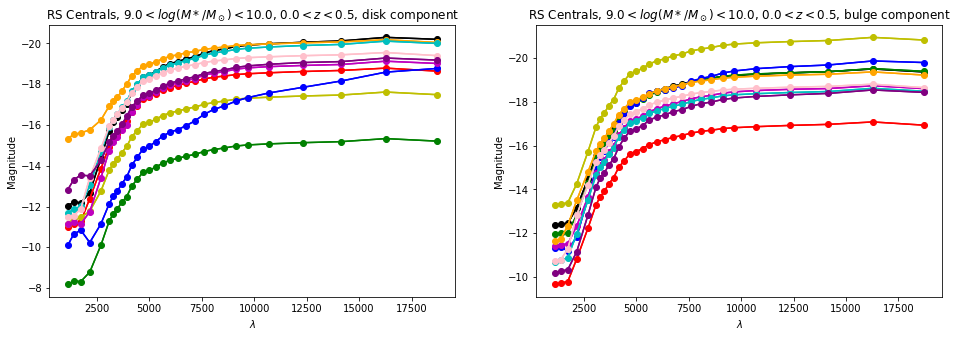

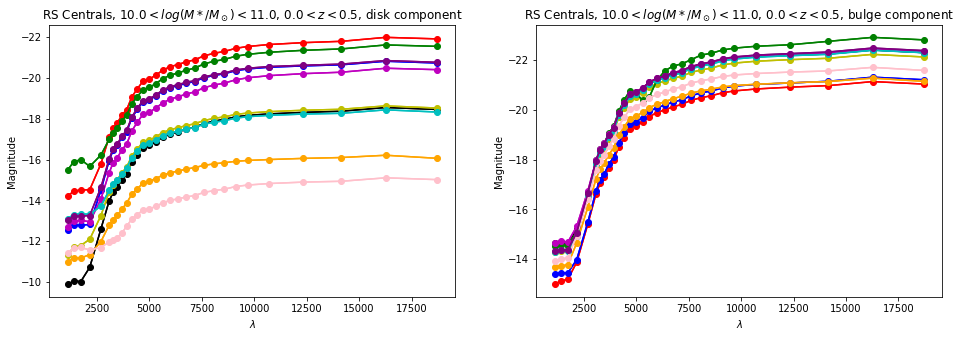

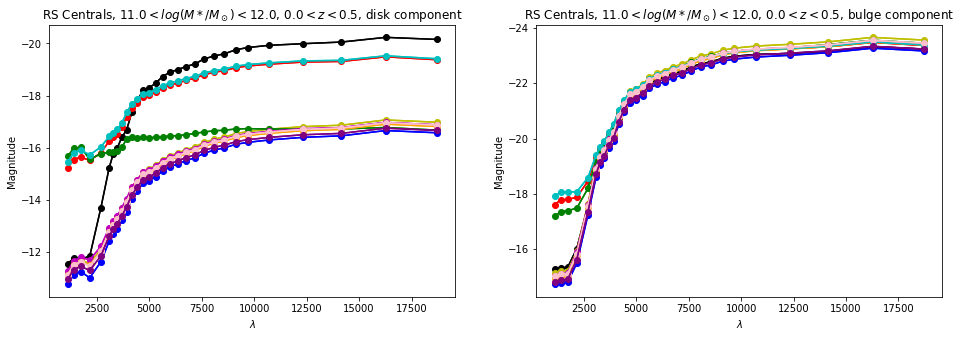

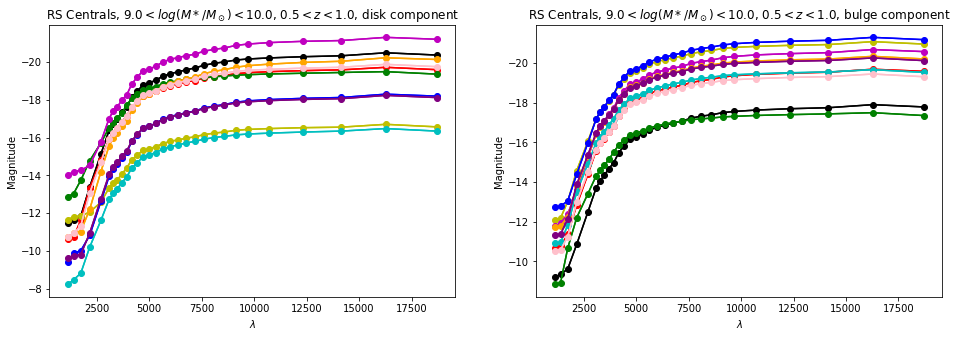

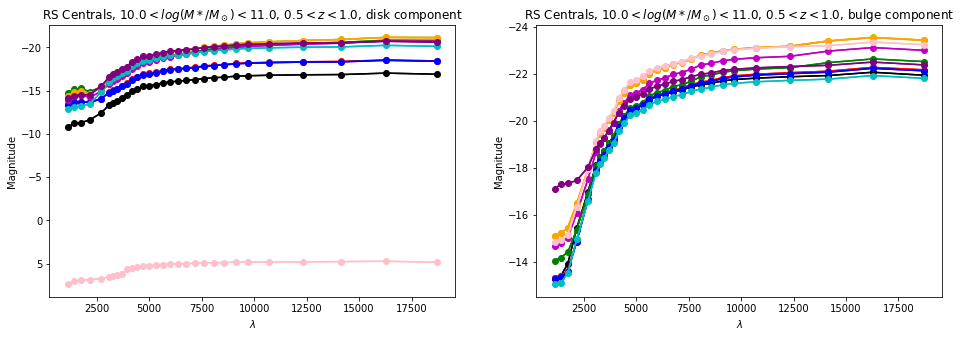

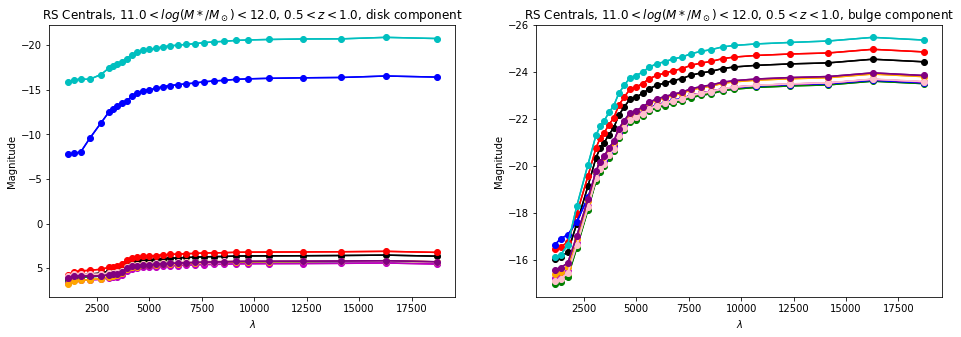

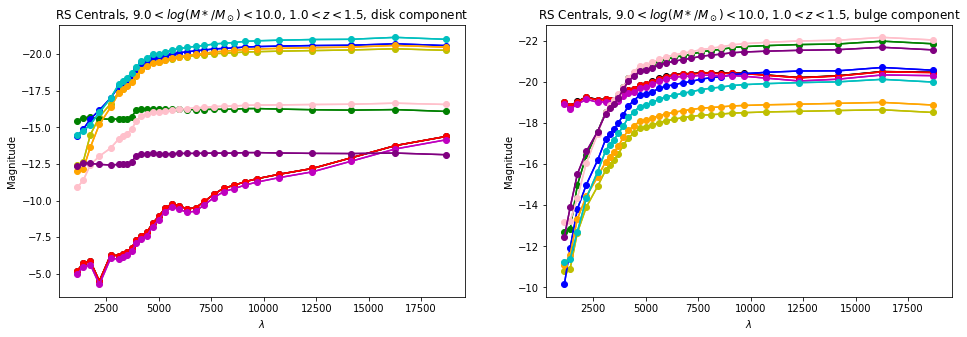

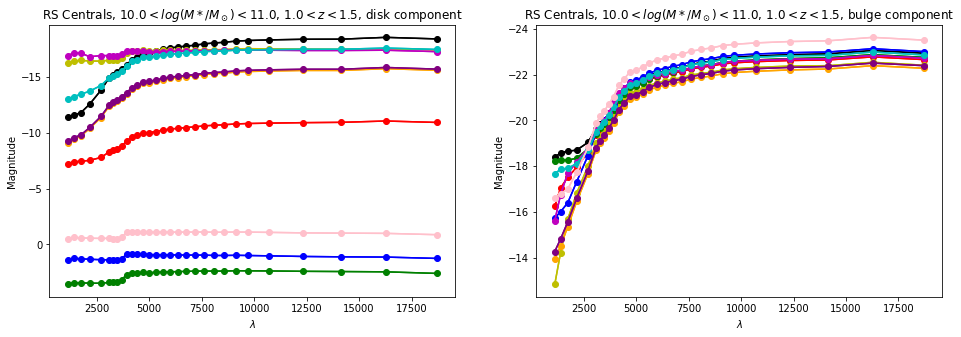

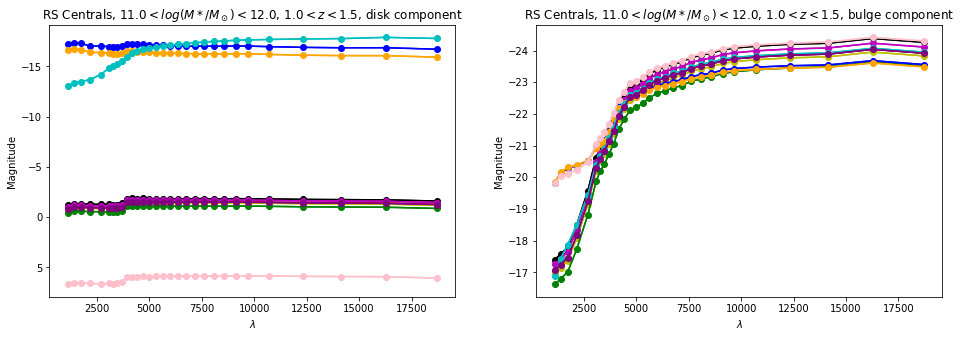

In [12]:
data = catdata[catalogs[0]]
#components = ['', 'disk', 'bulge']
components = ['disk', 'bulge']
figdir='./'
code ='ri'
number=10
colors = ['black', 'r', 'y', 'g', 'blue', 'm', 'orange', 'c', 'pink', 'purple']
rsmask = (data['is_central']) & (data['baseDC2/is_on_red_sequence_' + code])
print('#RS=', np.count_nonzero(rsmask))
mstar_cuts = np.logspace(9., 12., 4)
zcuts = np.linspace(0., 1.5, 4)
#make plots of some representative SEDs
results = analyse_SEDs(data, sed_keys, lambda_c, mstar_cuts, zcuts, mask=rsmask, number=number, plot_SED=True,
             colors=colors, catalog=catalogs[0], figdir=figdir, mask_label='RS Centrals')

The following cell evaluates the PCA decomposition for the above mass and redshift bins. However, the number of objects in each bins is limited and the decomposition becomes noisy after the first 2 components. We will skip this cell and instead move on to using the whole sample.

In [ ]:
#results = analyse_SEDs(data, sed_keys, lambda_c, mstar_cuts, zcuts, mask=rsmask, number=number, pca=True, NPCA=5,
#             colors=colors, catalog=catalogs[0], figdir=figdir, mask_label='RS Centrals')

In [17]:
#get PCA decomposition for entire dataset with mask
def PCA_data(data, sed_keys, mask=None, components=[], NPCA=None):
    """
    Get PCA decomposition for dataset and return results as new dict entry
    """
    if mask is None:
        mask = np.ones(len(data[sed_keys[0]]), dtype=bool)
    print('#=', np.count_nonzero(mask))
    if NPCA is None:
        NPCA = len([k for k in sed_keys if components[0] in k])
    print('NPCA=',NPCA)
    evectors = {}
    #initialize new data columns
    
    for c in components:
        #initialize new data columns
        sed_keys = sorted([k for k in SED_keys if c in k], key=stringSplitByIntegers)
        fluxes = get_fluxes(data, sed_keys, mask=mask)
        evecs, coeffs = get_PCA_fit(fluxes)
        print('shapes:', evecs.shape, coeffs.shape)
        for npca in range(NPCA):
            #initialize new data columns to nans
            newkey = '_'.join(['PCA', c, str(npca)])
            data[newkey] = np.array([np.nan]*len(mask))
            #fill selected rows with coefficients
            #print(len(data[newkey][mask]), len(coeffs[:,npca]))
            data[newkey][mask] = coeffs[:,npca]
        evectors[c] = evecs
    
    return evectors, data


def plot_evectors(evectors, lambda_c, components=components, colors=None, 
                  catalog='', figdir='./', mask_label='', NPCA=5):
    fig, axall = plt.subplots(1, 2, figsize=(16, 5))
    for i, c in enumerate(components):
        ax = axall.flat[i]
        for n, (evec, color) in enumerate(zip(evectors[c][0:NPCA], colors[0:NPCA])):
            ax.plot(lambda_c, evec, label=' '.join(['Eigenvector', str(n)]), color=color)
            ax.set_xlabel('$\lambda$')
            ax.set_ylabel('PCA Component')
            ax.legend(loc='best', fontsize='small')
            fig_id = 'PCAcomponents'
            ax.set_title(', '.join([mask_label, c+' component']))
            
    figname = '{}_{}.png'.format(fig_id, catalog)
    print('Saving {}'.format(figname))
    figfile = os.path.join(figdir, figname)
    fig.savefig(figfile, bbox_inches='tight')    

Note that we have added the PCA coefficients to the data dict. This is so we can subdivide by mass and redshift later and look for trends. We add some checks to make sure that the code is working as expected.

In [18]:
evectors, data = PCA_data(data, sed_keys, mask=rsmask, components=components, NPCA=NSED)
print([k for k in data.keys() if 'PCA' in k])
print(evectors.keys())

#= 3275257
NPCA= 30
shapes: (30, 30) (3275257, 30)
shapes: (30, 30) (3275257, 30)
['PCA_disk_0', 'PCA_disk_1', 'PCA_disk_2', 'PCA_disk_3', 'PCA_disk_4', 'PCA_disk_5', 'PCA_disk_6', 'PCA_disk_7', 'PCA_disk_8', 'PCA_disk_9', 'PCA_disk_10', 'PCA_disk_11', 'PCA_disk_12', 'PCA_disk_13', 'PCA_disk_14', 'PCA_disk_15', 'PCA_disk_16', 'PCA_disk_17', 'PCA_disk_18', 'PCA_disk_19', 'PCA_disk_20', 'PCA_disk_21', 'PCA_disk_22', 'PCA_disk_23', 'PCA_disk_24', 'PCA_disk_25', 'PCA_disk_26', 'PCA_disk_27', 'PCA_disk_28', 'PCA_disk_29', 'PCA_bulge_0', 'PCA_bulge_1', 'PCA_bulge_2', 'PCA_bulge_3', 'PCA_bulge_4', 'PCA_bulge_5', 'PCA_bulge_6', 'PCA_bulge_7', 'PCA_bulge_8', 'PCA_bulge_9', 'PCA_bulge_10', 'PCA_bulge_11', 'PCA_bulge_12', 'PCA_bulge_13', 'PCA_bulge_14', 'PCA_bulge_15', 'PCA_bulge_16', 'PCA_bulge_17', 'PCA_bulge_18', 'PCA_bulge_19', 'PCA_bulge_20', 'PCA_bulge_21', 'PCA_bulge_22', 'PCA_bulge_23', 'PCA_bulge_24', 'PCA_bulge_25', 'PCA_bulge_26', 'PCA_bulge_27', 'PCA_bulge_28', 'PCA_bulge_29']
dict_ke

Plot the first 5 eigenvectors. The 0th component captures the basic shape of the SED. Components 3 and 4 are starting to look noisy.

Saving PCAcomponents_cosmoDC2_v1.1.4_image.png


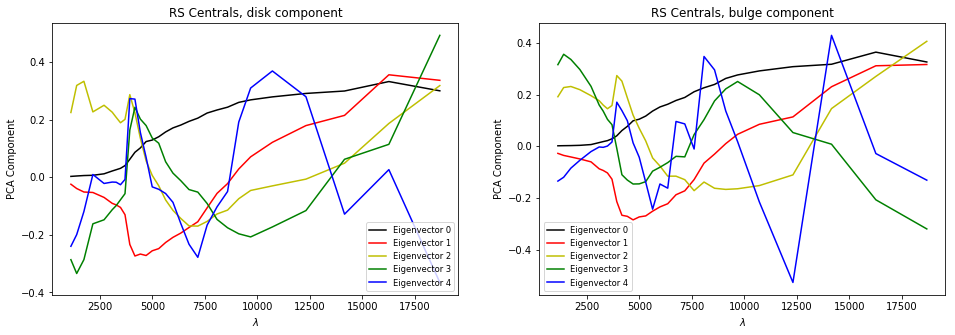

In [19]:
plot_evectors(evectors, lambda_c, components=components, colors=colors, 
              catalog=catalogs[0], figdir=figdir, mask_label='RS Centrals')

Now select some properties to use to search for correlations with the PCA coefficients. Stellar mass, halo mass and colors are good candidates for properties that may be correlated with the coefficients. Define a function to compute the colors from magnitudes and add them to the data dict.

In [22]:
properties = ['stellar_mass', 'halo_mass', 'r-i', 'g-r']
#bands = ['u', 'g', 'r', 'i', 'z', 'y']
bands = ['g', 'r', 'i', 'z']
frames =['rest', 'obs']
Mtemplate = 'Mag_true_{}_lsst_z0'
mtemplate = 'mag_{}_lsst'
def get_colors(bands, color_dict, key_template):
    newkeys = []
    frame = 'rest' if 'z0' in key_template else 'obs'
    for b1, b2 in zip(bands[0:-1], bands[1:]):
        k1 = key_template.format(b1)
        k2 = key_template.format(b2)
        newkey = '('+b1+'-'+b2+')_'+frame
        newkeys.append(newkey)
        color_dict[newkey] = color_dict[k1] - color_dict[k2]
        
    print('Added keys:', newkeys)
    
    return color_dict

data = get_colors(bands, data, Mtemplate)
data = get_colors(bands, data, mtemplate)
print(data['(r-i)_rest'][0:20])

Added keys: ['(g-r)_rest', '(r-i)_rest', '(i-z)_rest']
Added keys: ['(g-r)_obs', '(r-i)_obs', '(i-z)_obs']
[0.3736229  0.34340286 0.1779995  0.24054146 0.23008919 0.22751999
 0.3776741  0.38726616 0.3613205  0.39560318 0.17113686 0.24002552
 0.17159271 0.21864605 0.16917992 0.13659477 0.32012367 0.2646942
 0.30352783 0.31533146]


Define a function to plot the distribution of a selected PCA coefficient versus some property for different redshift ranges.

In [23]:
#plot PCA coefficients
def plot_coefficients(data, npca, properties, z_cuts, components=[], mask=None, cmap='cool',
                      Nxbins=50, Nybins=50, catalog='', figdir='./', mask_label=''):
    
    if mask is None:
        mask = np.ones(len(data['PCA_disk_0']), dtype=bool)
    print('#'+mask_label, np.count_nonzero(mask))
    for p in properties:
        nrows = len(z_cuts[0:-1])
        fig, axall = plt.subplots(nrows, 2, figsize=(16, nrows*5))
        for nz, (zcutlo, zcuthi) in enumerate(zip(z_cuts[0:-1], z_cuts[1:])):
            zlabel = '${} < z < {}$'.format(zcutlo, zcuthi)
            zmask = (data['redshift'] > zcutlo) & (data['redshift'] <= zcuthi)
            print('#z=',zcutlo, zcuthi, np.count_nonzero(zmask))
            mask_this = zmask & mask
            print('#all=',np.count_nonzero(mask_this))
            for i, c in enumerate(components):
                ax = axall.flat[nz*2+i]
                ykey = '_'.join(['PCA', c, str(npca)])               
                if 'mass' in p:
                    xdata = np.log10(data[p])                    
                    subscript = '*' if 'stellar' in p else 'halo' 
                    xlabel = ''.join(['$\log10(M_{',subscript,'}/M_{\odot})$'])
                else:
                    xlabel = p
                    xdata = data[p]
                print(c, np.min(data[ykey][mask_this]), np.max(data[ykey][mask_this]))
                CD2, xedges, yedges = np.histogram2d(xdata[mask_this], data[ykey][mask_this],
                                                     bins=(Nxbins, Nybins))
                CD2masked = np.ma.masked_where(CD2.T==0.0, CD2.T)
                hd2 = ax.pcolormesh(xedges, yedges, CD2masked, cmap=cmap)#, alpha=alpha2d)
                cb2 = plt.colorbar(hd2, ax=ax)
                #ax.plot(xdata[mask_this], data[ykey][mask_this], label=mask_label, color=color, alpha=0.3)
                ax.set_xlabel(xlabel)
                ax.set_ylabel('PCA Coefficient '+str(npca))
                #ax.legend(loc='best', fontsize='small')
                fig_id = '_'.join(['PCAcoefficient',str(npca),'vs',p])
                ax.set_title(', '.join([mask_label, zlabel, c+' component']))
            
        figname = '{}_{:.2f}_lt_z_le_{:.2f}_{}.png'.format(fig_id, zcutlo, 
                                                            zcuthi, catalog)
        print('Saving {}'.format(figname))
        figfile = os.path.join(figdir, figname)
        fig.savefig(figfile, bbox_inches='tight')    

Make a further selection on stellar mass > 1e9, since we are interested in BGCs. Plot the behavior of PCA coefficient 0. Note the correlation with stellar mass for the bulge component. No correlations are observed with color, which is expected since colors characterize changes in shape from 0th eigenvector.

['disk', 'bulge']
#RS Centrals, M* > 1e9 76190
#z= 0.0 0.5 434508
#all= 7185
disk -27862596.047004648 4659225580.016181
bulge -56924558.808345675 36926002246.00295
#z= 0.5 1.0 1941244
#all= 14240
disk -27862596.047004692 7864771931.042226
bulge -56924558.808345675 48489588024.767365
#z= 1.0 1.5 3147527
#all= 16447
disk -27862596.04700144 1641485727.7150064
bulge -56924558.808345675 48873037837.10411
Saving PCAcoefficient_0_vs_stellar_mass_1.00_lt_z_le_1.50_cosmoDC2_v1.1.4_image.png
#z= 0.0 0.5 434508
#all= 7185
disk -27862596.047004648 4659225580.016181
bulge -56924558.808345675 36926002246.00295
#z= 0.5 1.0 1941244
#all= 14240
disk -27862596.047004692 7864771931.042226
bulge -56924558.808345675 48489588024.767365
#z= 1.0 1.5 3147527
#all= 16447
disk -27862596.04700144 1641485727.7150064
bulge -56924558.808345675 48873037837.10411
Saving PCAcoefficient_0_vs_halo_mass_1.00_lt_z_le_1.50_cosmoDC2_v1.1.4_image.png
#z= 0.0 0.5 434508
#all= 7185
disk -27862596.047004648 4659225580.016181
bul

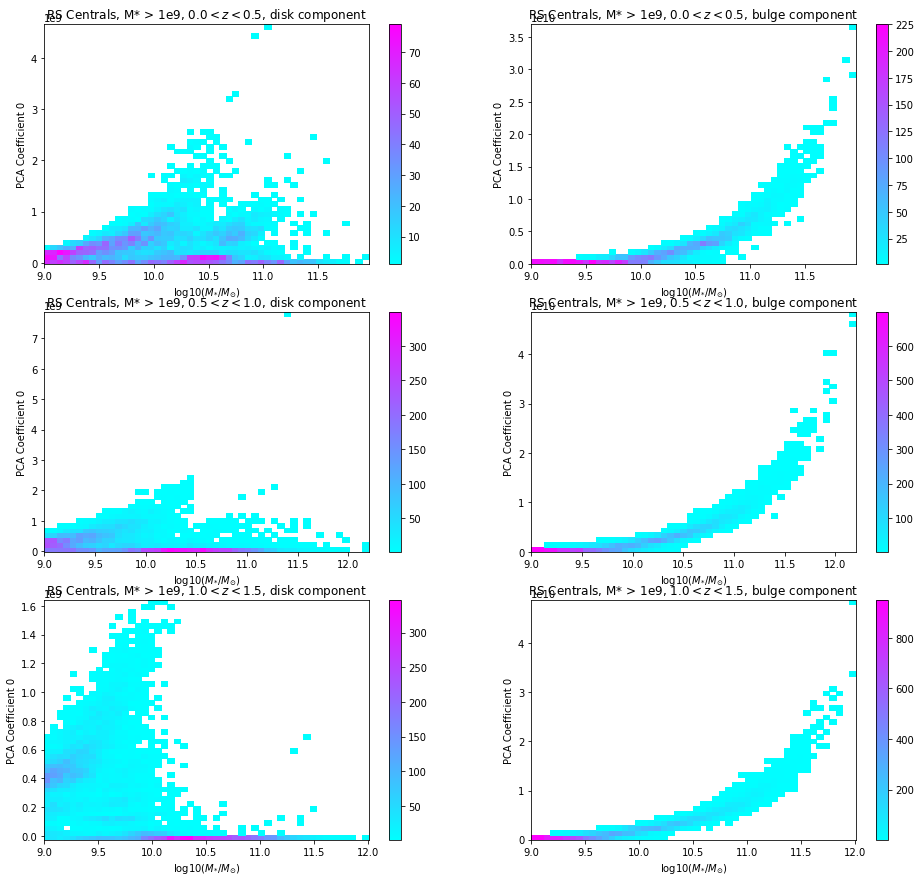

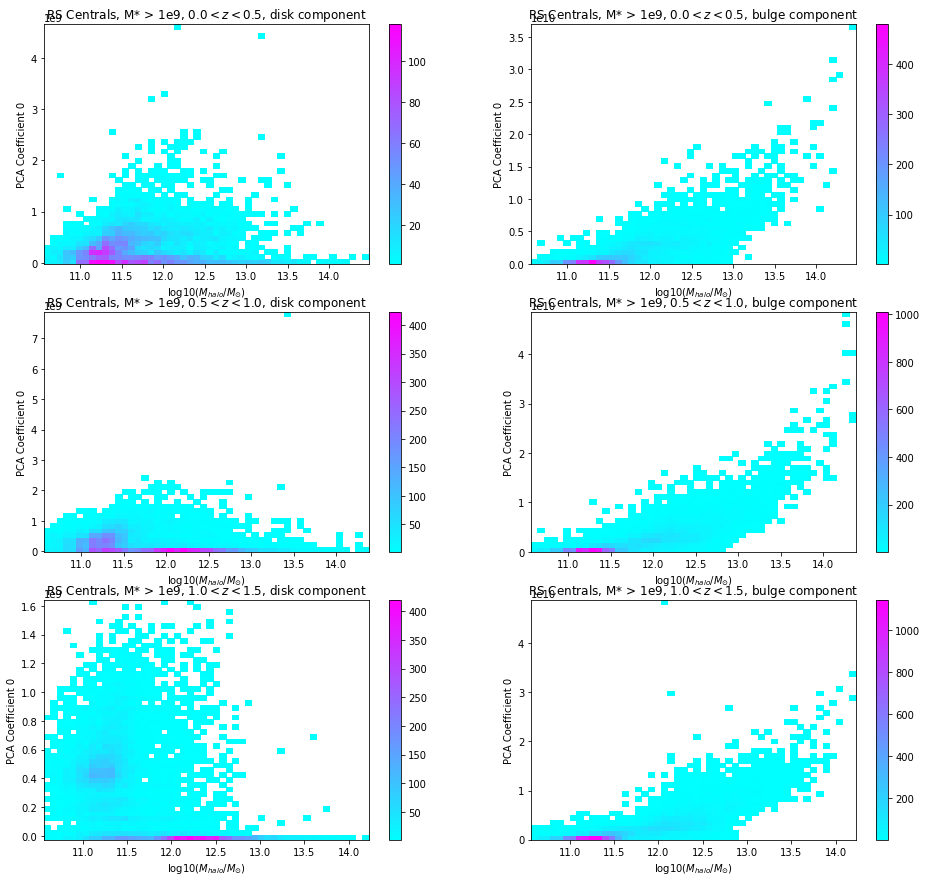

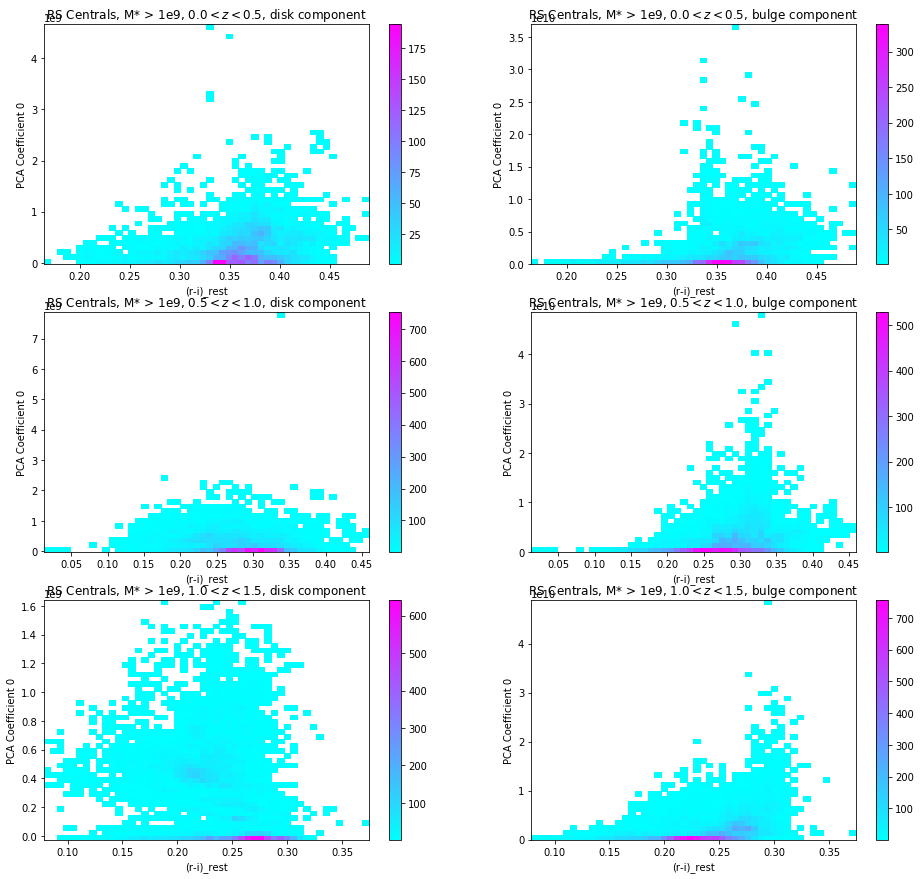

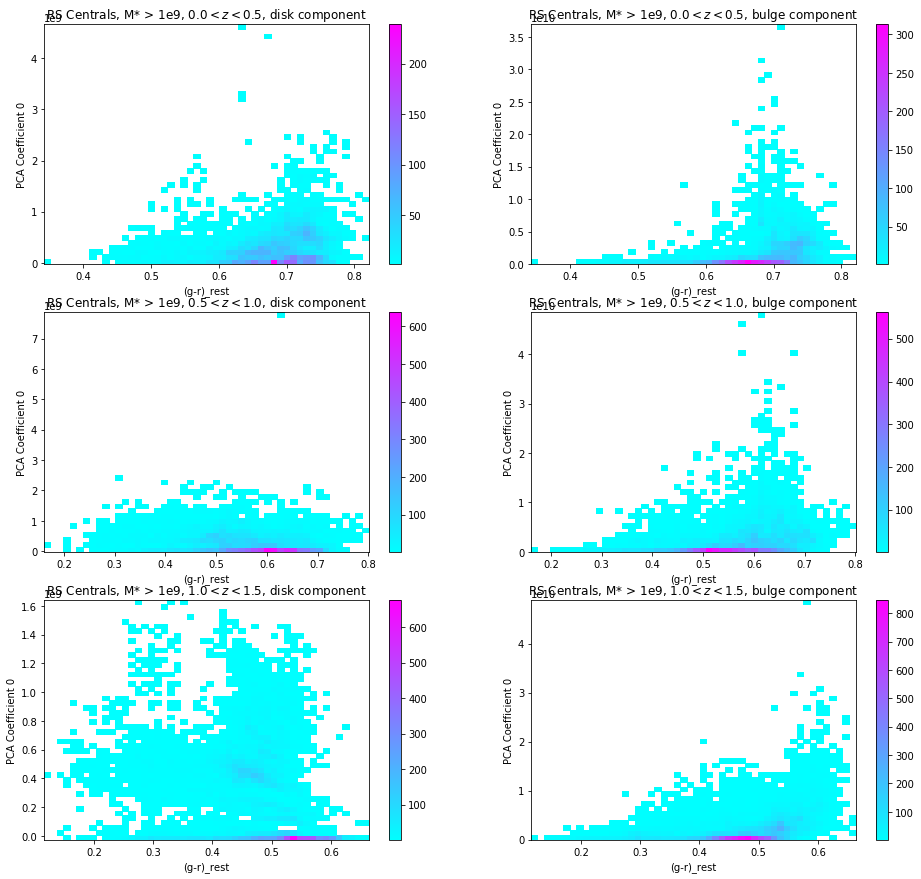

In [24]:
properties = ['stellar_mass', 'halo_mass', '(r-i)_rest', '(g-r)_rest']
print(components)
mass_mask = data['stellar_mass'] > 1e9
mask_all = mass_mask & rsmask
plot_coefficients(data, 0, properties, zcuts, mask=mask_all, components=components, 
                      catalog=catalogs[0], figdir=figdir, mask_label='RS Centrals, M* > 1e9')

Now look at the behavior of PCA coefficent 1. There is still some correlation with stellar mass, and a very mild correlation with color for the disk component. However nothing striking is seen.

#RS Centrals, M* > 1e9 76190
#z= 0.0 0.5 434508
#all= 7185
disk -77029439.2967292 642853761.3145223
bulge -89153501.59790225 3659976094.958721
#z= 0.5 1.0 1941244
#all= 14240
disk -259230446.90761682 1243972428.7528594
bulge -1302349533.4024155 2714619514.774789
#z= 1.0 1.5 3147527
#all= 16447
disk -254627371.43979326 114567697.46042383
bulge -1645219545.2417533 1259838891.9626756
Saving PCAcoefficient_1_vs_stellar_mass_1.00_lt_z_le_1.50_cosmoDC2_v1.1.4_image.png
#z= 0.0 0.5 434508
#all= 7185
disk -77029439.2967292 642853761.3145223
bulge -89153501.59790225 3659976094.958721
#z= 0.5 1.0 1941244
#all= 14240
disk -259230446.90761682 1243972428.7528594
bulge -1302349533.4024155 2714619514.774789
#z= 1.0 1.5 3147527
#all= 16447
disk -254627371.43979326 114567697.46042383
bulge -1645219545.2417533 1259838891.9626756
Saving PCAcoefficient_1_vs_halo_mass_1.00_lt_z_le_1.50_cosmoDC2_v1.1.4_image.png
#z= 0.0 0.5 434508
#all= 7185
disk -77029439.2967292 642853761.3145223
bulge -89153501.59790225 

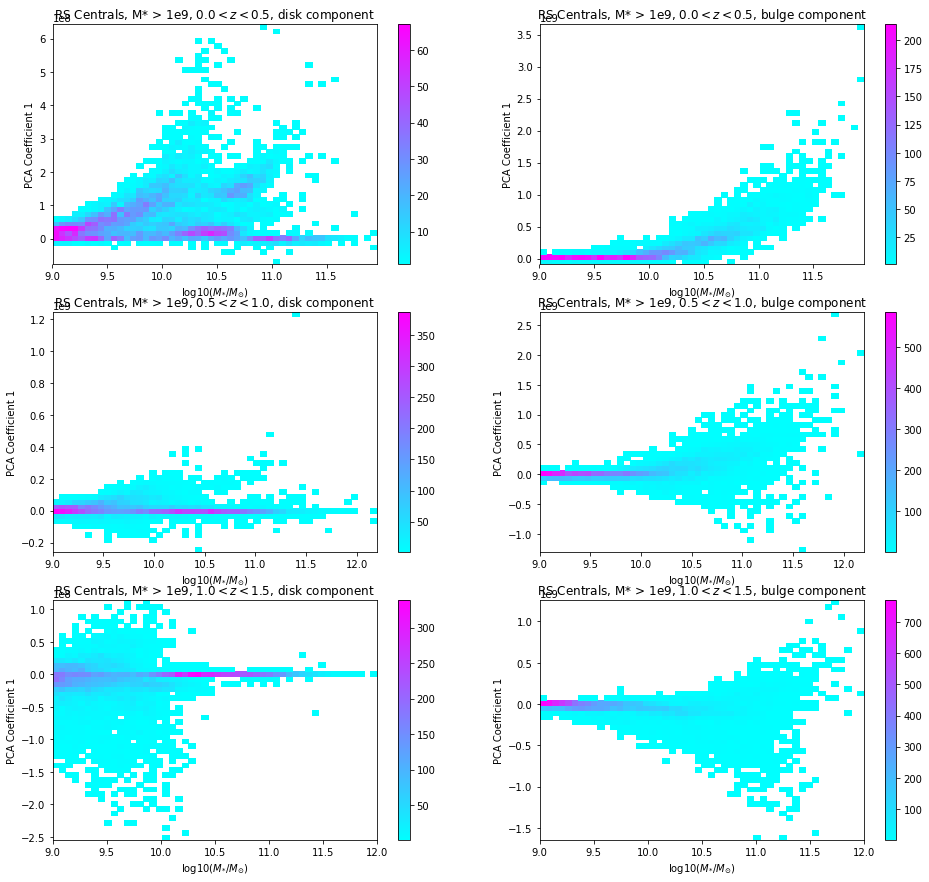

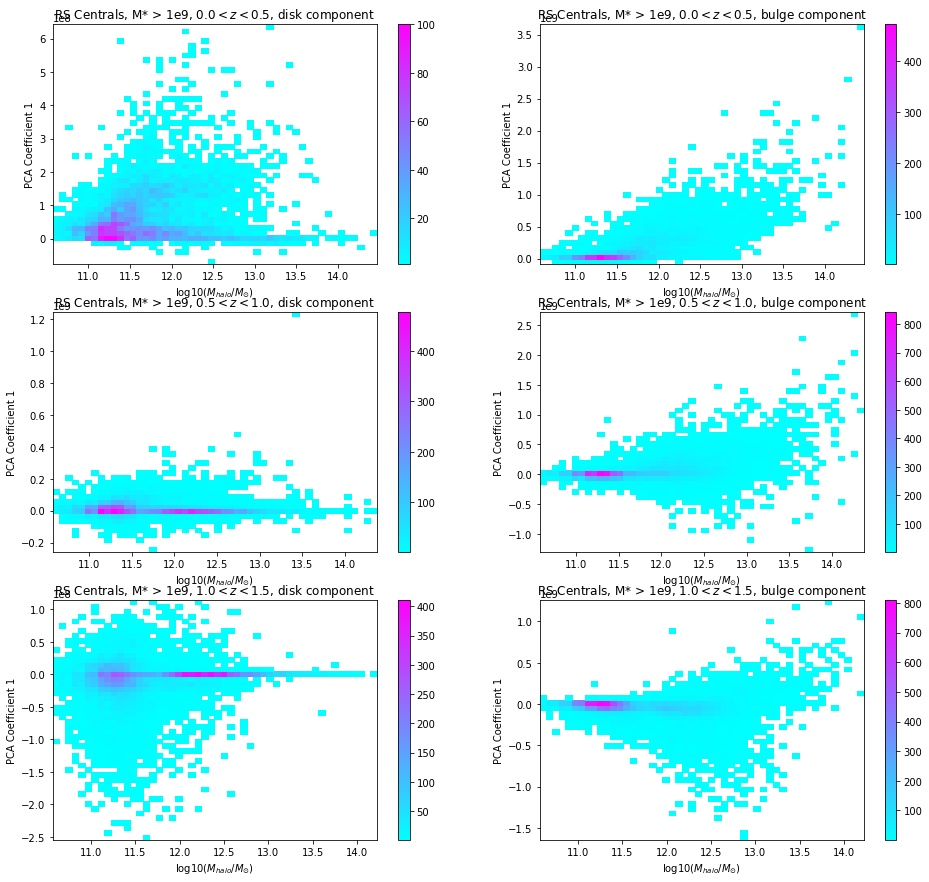

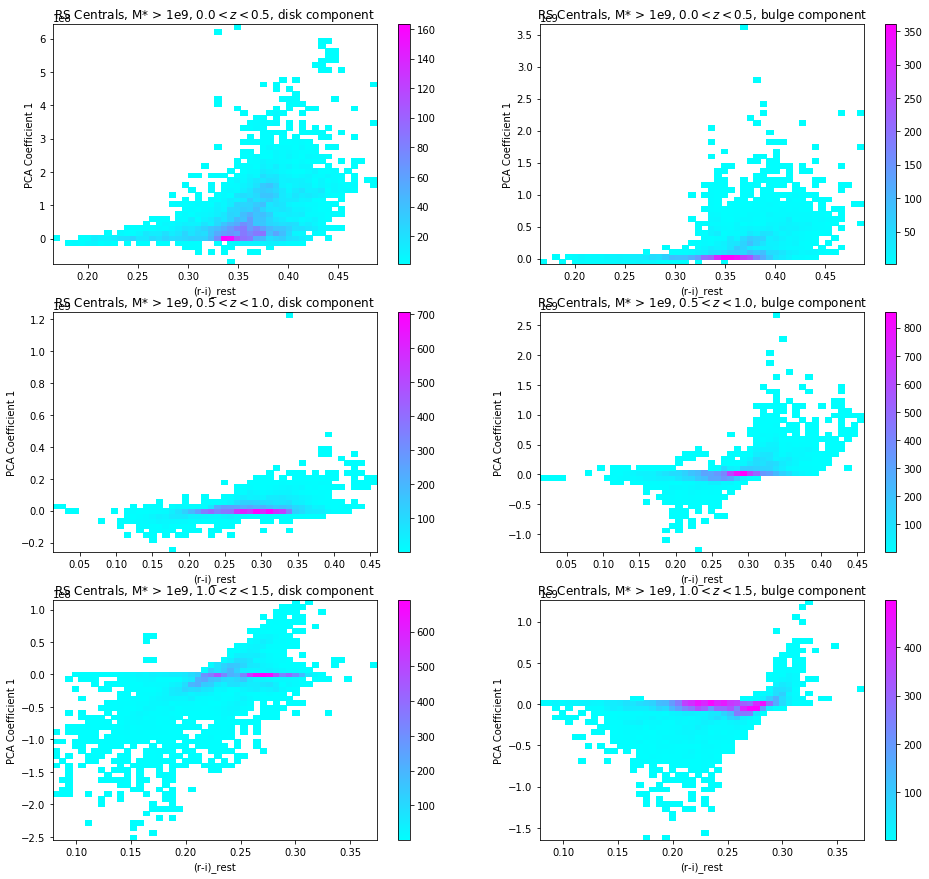

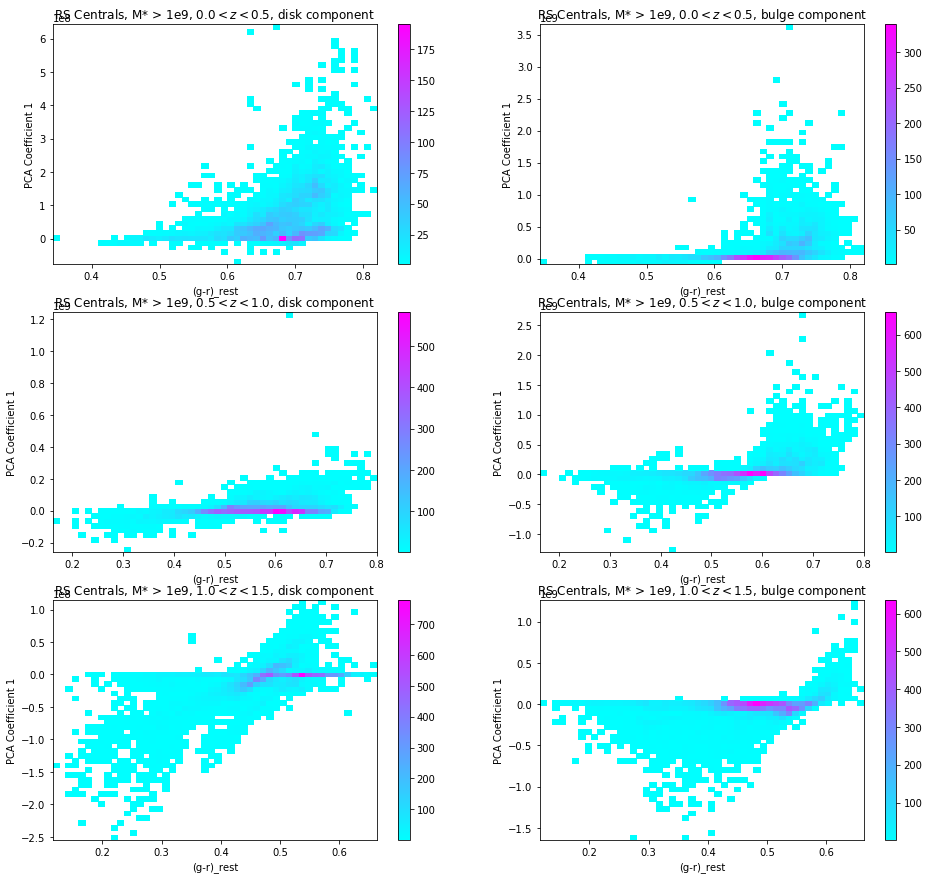

In [25]:
plot_coefficients(data, 1, properties, zcuts, mask=mask_all, components=components, 
                      catalog=catalogs[0], figdir=figdir, mask_label='RS Centrals, M* > 1e9')

Finally for completeness, here are the plost for PCA coefficient 2. No significant correlations are observed.

#RS Centrals, M* > 1e9 76190
#z= 0.0 0.5 434508
#all= 7185
disk -20626790.764509074 115595255.96507172
bulge -226490119.94795957 754132271.3739936
#z= 0.5 1.0 1941244
#all= 14240
disk -19258259.298110634 140443037.83070135
bulge -342566596.48054045 675569317.7827361
#z= 1.0 1.5 3147527
#all= 16447
disk -16759363.356452292 185205086.43556178
bulge -262282233.20880413 796180329.4903467
Saving PCAcoefficient_2_vs_stellar_mass_1.00_lt_z_le_1.50_cosmoDC2_v1.1.4_image.png
#z= 0.0 0.5 434508
#all= 7185
disk -20626790.764509074 115595255.96507172
bulge -226490119.94795957 754132271.3739936
#z= 0.5 1.0 1941244
#all= 14240
disk -19258259.298110634 140443037.83070135
bulge -342566596.48054045 675569317.7827361
#z= 1.0 1.5 3147527
#all= 16447
disk -16759363.356452292 185205086.43556178
bulge -262282233.20880413 796180329.4903467
Saving PCAcoefficient_2_vs_halo_mass_1.00_lt_z_le_1.50_cosmoDC2_v1.1.4_image.png
#z= 0.0 0.5 434508
#all= 7185
disk -20626790.764509074 115595255.96507172
bulge -226490119

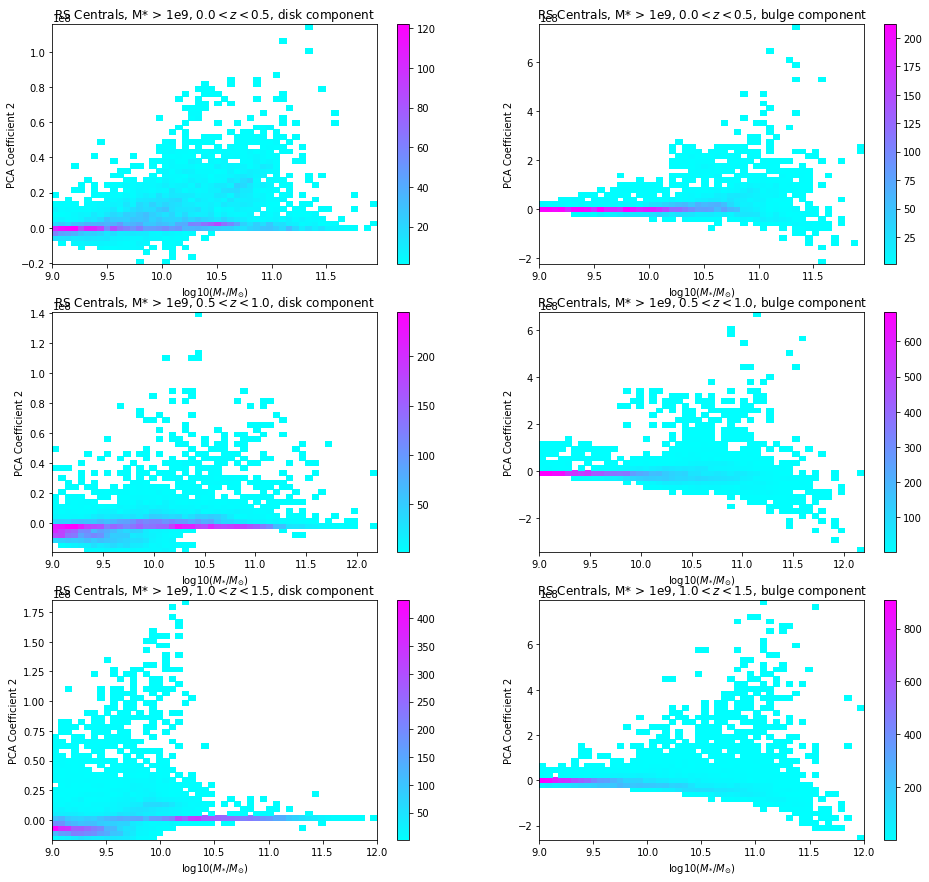

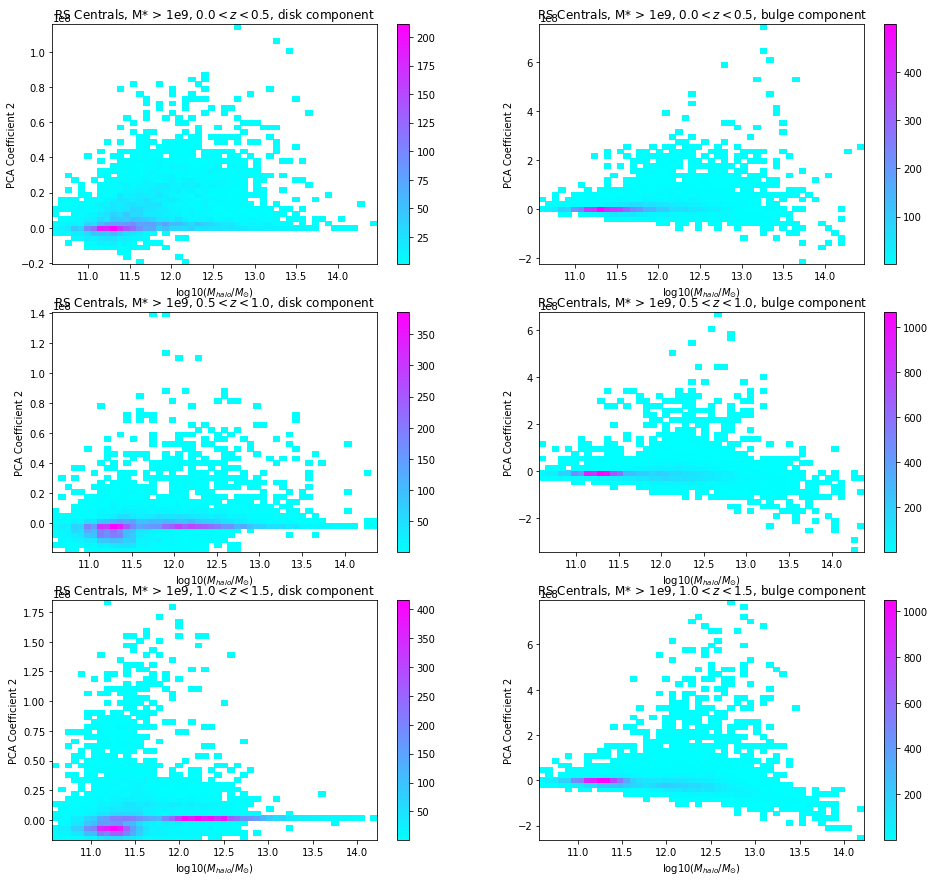

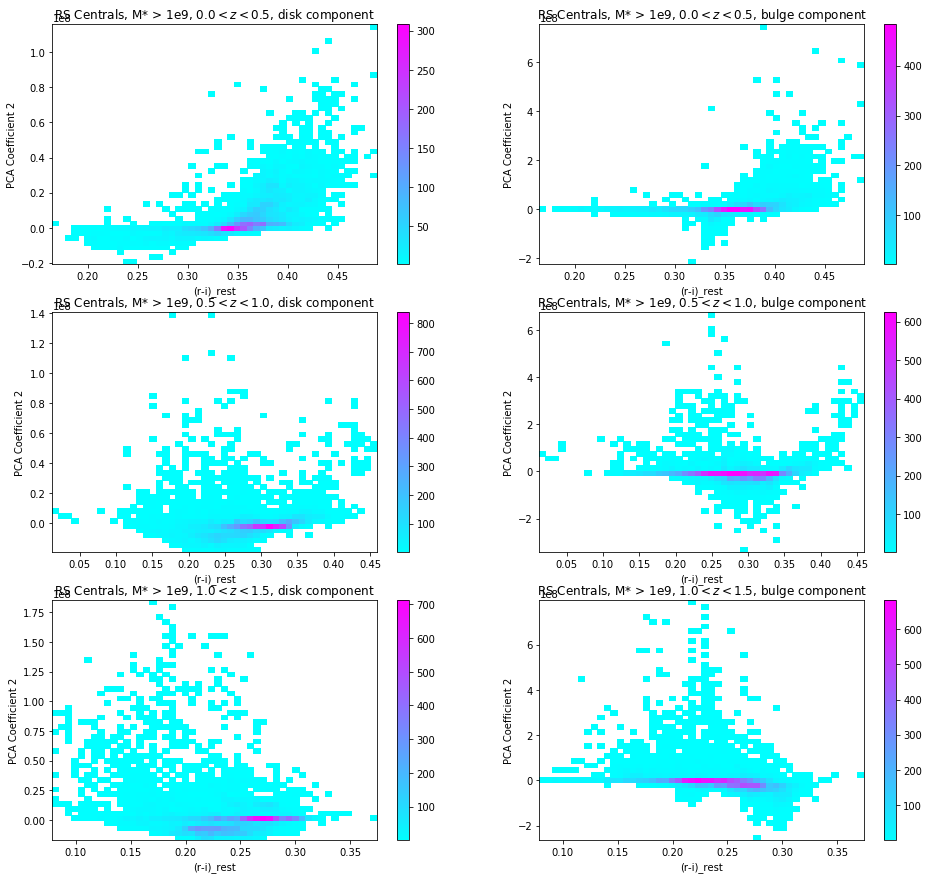

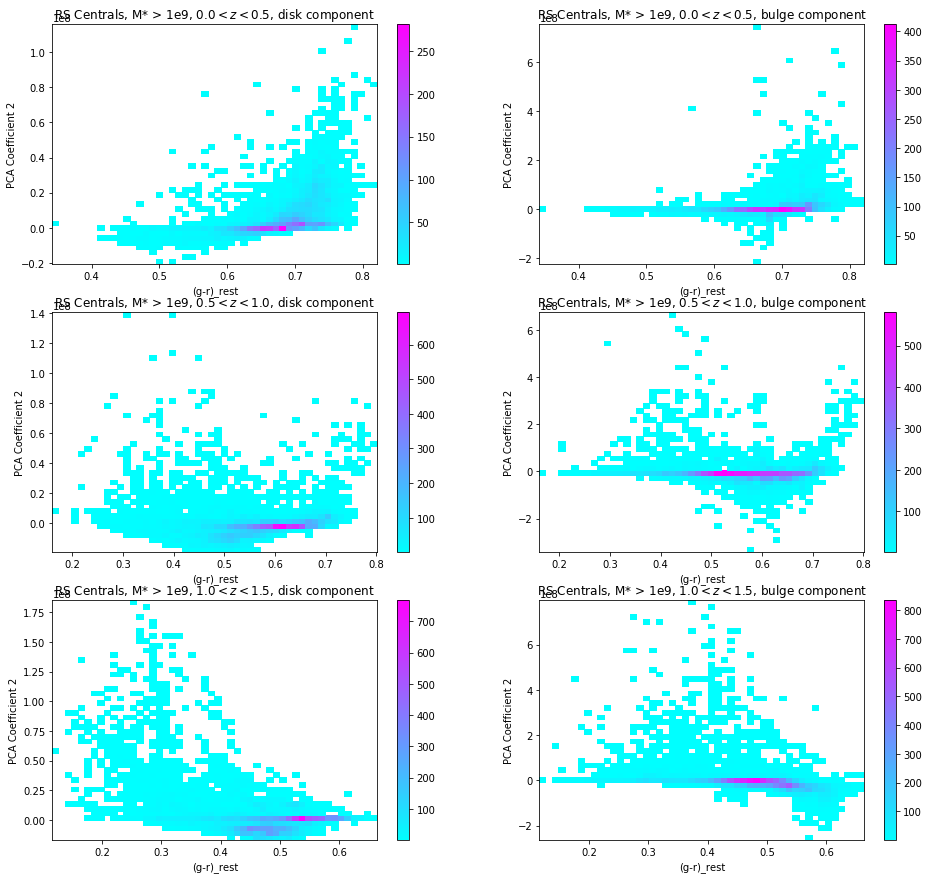

In [26]:
plot_coefficients(data, 2, properties, zcuts, mask=mask_all, components=components, 
                      catalog=catalogs[0], figdir=figdir, mask_label='RS Centrals, M* > 1e9')

The results shown in this notebook demonstrate that stellar mass would be a useful variable for modeling the SED of the bulge component of BCGs and that stellar mass and color could be used for modeling the disk component. Correlations with other variables remain to be explored.